In [306]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nue as nue
from tqdm import tqdm
import importlib
____ = importlib.reload(nue)

nue.signal_dict = {"nue1eNp0pi":0,
                   "nueCC"  :1,
                   "numuCC" :2,
                   "nuNC"   :3,
                   "nuOther":4,
                   "dirt"   :5,
                   "cosmic" :6}
nue.signal_labels = [r"CC $\nu_e$ Np0$\pi$",
                     r"Other CC $\nu_e$ ",
                     r"CC $\nu_\mu$",
                     r"NC $\nu$",
                     r"Other $\nu$",
                     r"Dirt $\nu$",
                     "cosmic"]
nsignals = len(nue.signal_labels)

nue.colors = ["deepskyblue","C0", "C1", "C2", "C3", "C4", "C5", "C6"]
nu_idx_set =  ["ntuple","entry","rec.mc.nu__index"]
slc_idx_set = ["ntuple","entry","rec.slc__index"]

In [6]:
def redefine_signals(df: pd.DataFrame):
    nuprim_df = df.copy()
    # get masks 
    whereFV = nue.maskTrueVtxFv(nuprim_df)
    whereCCnue = ((nuprim_df.iscc==1) &  # require CC interaction
                (abs(nuprim_df.pdg)==12) &  # require neutrino to be a nue
                (abs(nuprim_df.prim.pdg)==11) & # require electron to be the primary (?) 
                (nuprim_df.prim.startE-nuprim_df.prim.endE > 0.2) ) # require primary electron to deposit 200 MeV 

    # define interaction types 
    nuprim_df = nue.defineBackground(nuprim_df)
    nuprim_df["signal"] = np.where(whereFV & whereCCnue,
                                nue.signal_dict["nueCC"],
                                nuprim_df["signal"])
    # get pdg counts 
    pdg_counts = nue.getPDGCounts(nuprim_df)

    # flatten to and keep only the first primary entry (electron)
    # merge the pdg counts into the dataframe
    nu_df = nue.flatten_df(nuprim_df.loc[:,:,:,0])
    nu_df["nu_index"] = nu_df["rec.mc.nu__index"]
    nu_df = nu_df.merge(pdg_counts,how="left",on=nu_idx_set)

    # define nue1eNp0pi signal, ensure that the signal is also CC nue with same electron energy cut
    nu_df["signal"] = np.where(nu_df.eval(("(signal==1) \
                                            & (`e-` ==1)\
                                            & ( pi0 ==0)\
                                            & (`pi+`==0)\
                                            & (p>0)")),
                                nue.signal_dict["nue1eNp0pi"],
                                nu_df["signal"])
    return nu_df

In [2]:
# load dataframes from cafs
nue_file = "/sbnd/data/users/lynnt/v09_75_03_03/intrnue_data.df"
nue_hdr_df_0 = pd.read_hdf(nue_file,key="hdr")
nue_nuprim_df_0 = pd.read_hdf(nue_file,key="mcnuprim")

bnb_file = "/sbnd/data/users/lynnt/v09_75_03_03/rockbox.df"
bnb_hdr_df_0 = pd.read_hdf(bnb_file,key="hdr")
bnb_nuprim_df_0 = pd.read_hdf(bnb_file,key="mcnuprim")

int_file = "/sbnd/data/users/lynnt/v09_75_03_03/intime.df"
int_hdr_df_0 = pd.read_hdf(int_file,key="hdr")

In [7]:
# load slc dataframes
slc_ro_nue_df = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df_slc/ana_intrnue_slcpfp_opt_raz.pkl").sort_values("entry")
slc_ro_bnb_df = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df_slc/ana_rockbox_slcpfp_opt_raz.pkl").sort_values("entry")
slc_ro_int_df = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df/ana_intime_slcpfp_opt_raz.pkl").sort_values("entry")

slc_ro_nue_df.rename(columns={"nu_index":"rec.mc.nu__index"},inplace=True)
slc_ro_bnb_df.rename(columns={"nu_index":"rec.mc.nu__index"},inplace=True)
slc_ro_int_df.rename(columns={"nu_index":"rec.mc.nu__index"},inplace=True)

In [8]:
# redefine signals
nue_nu_df = redefine_signals(nue_nuprim_df_0)
bnb_nu_df = redefine_signals(bnb_nuprim_df_0)

In [307]:
# scalings
# scale by the # of FV nue interactions
nnue_bnb_FV = len(bnb_nu_df.query("((signal==0) | (signal==1) | (signal==3) | (signal==4)) & (abs(pdg)==12)"))
nnue_nue_FV = len(nue_nu_df.query("((signal==0) | (signal==1) | (signal==3) | (signal==4)) & (abs(pdg)==12)"))
nue.nue_scale = nnue_bnb_FV/nnue_nue_FV
nue_scale_err = np.sqrt( 1/nnue_bnb_FV + 1/nnue_nue_FV)*nue.nue_scale
print(fr"nue scale +/- err: {nue.nue_scale:.5f} +- {nue_scale_err:.5f}")

year_pot = 3.3e20
year_scale = year_pot/np.sum(bnb_hdr_df_0.rec.hdr.pot)
month3_scale = year_scale/4

# scale intime cosmics by # of generated events
bnb_genevt = np.sum(nue.flatten_df(bnb_hdr_df_0).drop_duplicates(subset=["ntuple","rec_hdr_subrun"]).rec_hdr_ngenevt)
int_genevt = np.sum(nue.flatten_df(int_hdr_df_0).drop_duplicates(subset=["ntuple","rec_hdr_subrun"]).rec_hdr_ngenevt)

p_intime = len((slc_ro_int_df).drop_duplicates(subset=["ntuple","entry"]))/int_genevt 
p_bnb    = len((bnb_nu_df).drop_duplicates(subset=["ntuple","entry"]))/bnb_genevt
p_both   = p_intime*p_bnb

print("probability of an intime cos event:", round(p_intime,4))
print("probability of a bnb rockbox event:", round(p_bnb,4))
print("probability of both: ",            round(p_both,4))
# to avoid double-counting, we need to subtract the 0.002 of int_genevt 
int_scale = (bnb_genevt*(1-p_both))/ (int_genevt) 
int_scale_err = np.sqrt(1/bnb_genevt + 1/int_genevt)*int_scale
print(fr"intime scale +/- err: {int_scale:.5f} +- {int_scale_err:.5f}")

nue scale +/- err: 0.00833 +- 0.00039
probability of an intime cos event: 0.0116
probability of a bnb rockbox event: 0.1754
probability of both:  0.002
intime scale +/- err: 0.14973 +- 0.00020


In [4]:
# apply signal definitions in nue 
slc_ro_nue_idx = slc_ro_nue_df.set_index(nu_idx_set).sort_index()
nue_nu_idx     = nue_nu_df.set_index(nu_idx_set).sort_index()
full_slc_ro_nue_nu_df  = slc_ro_nue_idx.join(nue_nu_idx,how="left")

# apply signal definitions in bnb 
slc_ro_bnb_idx = slc_ro_bnb_df.set_index(nu_idx_set).sort_index()
bnb_nu_idx     = bnb_nu_df.set_index(nu_idx_set).sort_index()
full_slc_ro_bnb_nu_df  = slc_ro_bnb_idx.join(bnb_nu_idx,how="left")

slc_ro_int_df["signal"] = nue.signal_dict["cosmic"]

# remove FV nue interactions from BNB rockbox sample 
# drop if the slc is attributed to a nue interaction in the FV 
dropBNB = full_slc_ro_bnb_nu_df.eval( ("((signal==0) | (signal==1) | (signal==3) | (signal==4)) & (abs(pdg)==12)"))
fix_slc_bnb_df = full_slc_ro_bnb_nu_df[~dropBNB]
fix_slc_bnb_df ["signal"] = np.where(fix_slc_bnb_df.slc_tmatch_idx<0, nue.signal_dict["cosmic"], fix_slc_bnb_df.signal)
slc_ro_bnb_nu_df = fix_slc_bnb_df.reset_index().copy()

# remove everything but FV nue interactions from nue sample 
slc_ro_nue_nu_df = full_slc_ro_nue_nu_df.query("(signal==0) | (signal==1) | (signal==3) | (signal==4)").reset_index()
slc_ro_nue_nu_df["signal"] = np.where(slc_ro_nue_nu_df.slc_tmatch_idx<0, nue.signal_dict["cosmic"], slc_ro_nue_nu_df.signal)

KeyboardInterrupt: 

In [10]:
# pd.to_pickle(slc_ro_nue_nu_df,"/sbnd/data/users/lynnt/v09_75_03_03/df_slc/slc_ro_nue_nu.pkl")
# pd.to_pickle(slc_ro_bnb_nu_df,"/sbnd/data/users/lynnt/v09_75_03_03/df_slc/slc_ro_bnb_nu.pkl")

# pd.to_pickle(full_slc_ro_nue_nu_df,"/sbnd/data/users/lynnt/v09_75_03_03/df_slc/full_slc_ro_nue_nu.pkl")
# pd.to_pickle(full_slc_ro_bnb_nu_df,"/sbnd/data/users/lynnt/v09_75_03_03/df_slc/full_slc_ro_bnb_nu.pkl")

slc_ro_nue_nu_df = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df_slc/slc_ro_nue_nu.pkl")
slc_ro_bnb_nu_df = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df_slc/slc_ro_bnb_nu.pkl")

full_slc_ro_nue_nu_df = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df_slc/full_slc_ro_nue_nu.pkl")
full_slc_ro_bnb_nu_df = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df_slc/full_slc_ro_bnb_nu.pkl")

## Selection Start!

In [310]:
def selection(df,shw_val=0.2,crumbs_val=0.25,muon_val=0.05,electron_val=0.9,frac_val=-0.15):
    df = df.copy()
    pre_df = nue.cutPreselection(df,whereShower=False)
    con_df = nue.cutContainment(pre_df.copy())
    # get total number of contained tracks and showers 
    nshw_df = pd.DataFrame(con_df.query("pfp_trackScore  < 0.5").groupby(slc_idx_set).size()).rename(columns={0:"nshw_cont"}).reset_index()
    ntrk_df = pd.DataFrame(con_df.query("pfp_trackScore >= 0.5").groupby(slc_idx_set).size()).rename(columns={0:"ntrk_cont"}).reset_index()
    # require that there is at least one contained shower and one contained track
    ncon_df = nshw_df.merge(ntrk_df,how="outer").fillna(value=0).query("(nshw_cont==1) & (ntrk_cont>0)")
    con_df = con_df.merge(ncon_df,how="right",on=slc_idx_set)
    con_df = con_df.sort_values(by=slc_idx_set+["rec.slc.reco.pfp__index"])
    # shower cut
    shw_df = con_df[con_df.shw_energy == con_df.groupby(slc_idx_set)["shw_energy"].transform(max)]
    shw_df = shw_df.query("shw_energy > @shw_val")
    lcr_df = nue.cutCRUMBS(shw_df,cut_val=crumbs_val)
    esl_df = lcr_df.query("slc_pfp_razzled_electron_score > @electron_val")
    
    mrj_trk_df = con_df.merge(esl_df[slc_idx_set].drop_duplicates(), how="right").query("pfp_trackScore>=0.5")
    mrj_trk_df = mrj_trk_df[mrj_trk_df["fix_trk_len"] == mrj_trk_df.groupby(slc_idx_set)["fix_trk_len"].transform(max)]
    mrj_trk_df = mrj_trk_df.query("slc_pfp_razzled_muon_score < @muon_val")
    mrj_df = esl_df.merge(mrj_trk_df[slc_idx_set].drop_duplicates(), how="right")
    
    df_names = ["preselection", "containment", "shw energy","cosmic rejection", "electron selection", "muon rejection"]
    df_dict = dict(zip(df_names,[pre_df,con_df,shw_df,lcr_df,esl_df, mrj_df]))
    return df_dict

In [311]:
nue_df_dict = selection(slc_ro_nue_nu_df)
bnb_df_dict = selection(slc_ro_bnb_nu_df)
int_df_dict = selection(slc_ro_int_df)

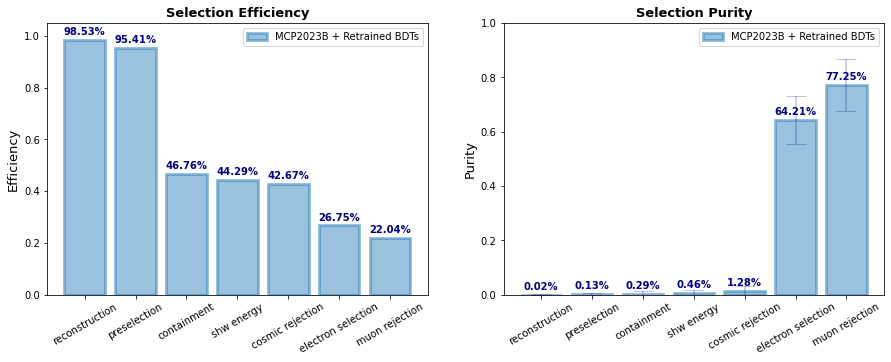

In [312]:
labels = list(nue_df_dict.keys())

# purity and efficiency after each step
eff_den = len(nue.get_signal_evt(nue_nu_df)) # total number of signal events

keys = list(nue_df_dict.keys())
nue_df_list = [slc_ro_nue_nu_df] + [nue_df_dict[key] for key in keys]
bnb_df_list = [slc_ro_bnb_nu_df] + [bnb_df_dict[key] for key in keys]
int_df_list = [slc_ro_int_df]    + [int_df_dict[key] for key in keys]
stages = ["reconstruction"] + labels

eff = np.zeros(len(nue_df_list))
pur = np.zeros(len(nue_df_list))
pur_err = np.zeros(len(nue_df_list))

for i in range(0,len(nue_df_list)):
    nue_df = nue_df_list[i]
    bnb_df = bnb_df_list[i]
    int_df = int_df_list[i]
    
    pur_num = len(nue.get_signal_slc(nue_df))*nue.nue_scale
    pur_den = len(nue.get_slc(nue_df))*nue.nue_scale + len(nue.get_slc(bnb_df)) + len(nue.get_slc(int_df))*int_scale
    eff_num = len(nue.get_signal_evt(nue_df))
    
    sig = pur_num
    sig_err = np.sqrt(sig)*nue.nue_scale 
    bkg = len(nue.get_slc(nue_df))*nue.nue_scale + len(nue.get_slc(bnb_df)) 
    bkg_err = np.sqrt(len(nue.get_slc(bnb_df)) + ((len(nue.get_slc(nue_df)))*nue.nue_scale))
    pur_err[i] = ((bkg)/(bkg+sig))*np.sqrt( (bkg_err/bkg)**2 + (bkg_err**2 + sig_err**2)/((bkg + sig)**2))

    eff[i] = eff_num/eff_den
    pur[i] = pur_num/pur_den
    
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].bar(stages,eff,label="MCP2023B + Retrained BDTs",alpha=0.45,lw=3,edgecolor="C0")
axes[1].bar(stages,pur,label="MCP2023B + Retrained BDTs",alpha=0.45,lw=3,edgecolor="C0")
axes[0].set_title("Selection Efficiency",fontsize=13,fontweight="bold")
axes[1].set_title("Selection Purity",fontsize=13,fontweight="bold")
axes[0].set_ylabel("Efficiency",fontsize=13)
axes[1].set_ylabel("Purity",fontsize=13)
axes[1].errorbar(stages,pur,yerr=pur_err,fmt='none',ecolor="navy",capsize=10,alpha=0.25)

for i in range(len(eff)):
    axes[0].text(i,eff[i]+0.02, f"{eff[i]*100:.2f}%",fontsize=10,ha='center',fontweight="bold",color="navy")
    axes[1].text(i,pur[i]+0.02, f"{pur[i]*100:.2f}%",fontsize=10,ha='center',fontweight="bold",color="navy")

axes[0].legend()
axes[1].legend()
axes[1].set_ylim(0,1.0)
axes[0].set_ylim(0,1.05)

# rotate the labels on the x-axis
axes[0].set_xticks(range(len(stages))); axes[0].set_xticklabels(stages,rotation=30)
axes[1].set_xticks(range(len(stages))); axes[1].set_xticklabels(stages,rotation=30)

plt.show()

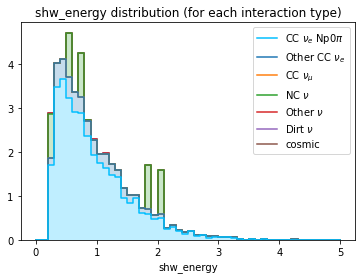

In [313]:
nue.plot_var(df=[nue_df_dict["muon rejection"],bnb_df_dict["muon rejection"],int_df_dict["muon rejection"]],
             scale=[nue.nue_scale,1,int_scale],
             var="shw_energy",
             bins=np.linspace(0,5,51))

In [ ]:
plt.figure(dpi=100)
bins=np.linspace(0,5,51)
plt.hist(nue_nu_df.query("signal==0").prim_startE - nue_nu_df.query("signal==0").prim_endE,
         bins=bins,
         histtype="step",
         lw=2,
         color="C0",
         density=True,
         label="Generated Events")
plt.hist(nue_df_dict["PE Fractional Difference"].prim_startE - nue_df_dict["PE Fractional Difference"].prim_endE,
         bins=bins,
         histtype="step",
         lw=2,
         color="C1",
         density=True,
         label="Selected Events")
plt.legend()
plt.title(r"True Primary Electron Energy Distribution (Counts)")
plt.xlabel("True Primary e- energy (GeV)")
plt.show()

In [300]:
len(nue.get_signal_evt(nue_df_dict["muon rejection"]))/month3_scale

525.57622642252

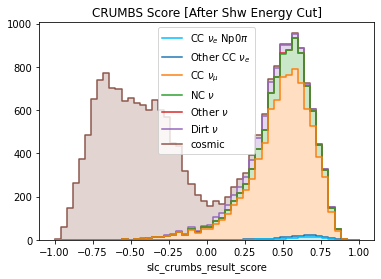

In [212]:
nue.plot_var(df=[shw_nue_df,shw_bnb_df,shw_int_df],
             scale=[nue.nue_scale,1,int_scale],
             var="slc_crumbs_result_score",
             title="CRUMBS Score [After Shw Energy Cut]",
             bins=np.linspace(-1,1,51),
            #  mult_factor=1.0
             )

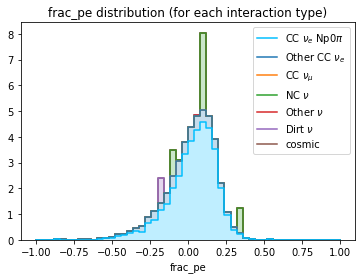

In [294]:
nue.plot_var(df=[nue_df_dict["muon rejection"], bnb_df_dict["muon rejection"], int_df_dict["muon rejection"]],
             scale=[nue.nue_scale,1,int_scale],
             var="frac_pe",
             bins=np.linspace(-1,1,51)
             )

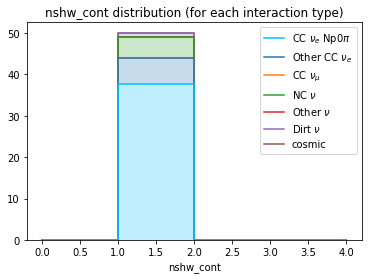

In [293]:
nue.plot_var(df=[nue_df_dict["muon rejection"], bnb_df_dict["muon rejection"], int_df_dict["muon rejection"]],
             scale=[nue.nue_scale,1,int_scale],
             var="nshw_cont",
             bins=np.arange(0,5)
             )

In [302]:
esl_nue_df = nue_df_dict["electron selection"]
esl_bnb_df = bnb_df_dict["electron selection"]
esl_int_df = int_df_dict["electron selection"]
esl_trk_nue_df = nue_df_dict["containment"].merge(esl_nue_df[slc_idx_set].drop_duplicates(), how="right").query("pfp_trackScore>=0.5")
esl_trk_bnb_df = bnb_df_dict["containment"].merge(esl_bnb_df[slc_idx_set].drop_duplicates(), how="right").query("pfp_trackScore>=0.5")
esl_trk_int_df = int_df_dict["containment"].merge(esl_int_df[slc_idx_set].drop_duplicates(), how="right").query("pfp_trackScore>=0.5")

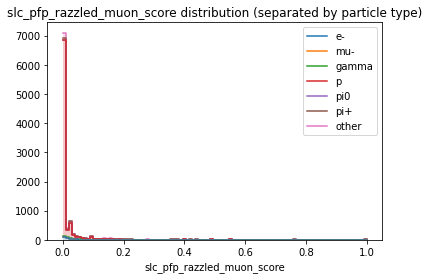

In [303]:
nue.plot_var_pdg(df = [esl_trk_nue_df,esl_trk_bnb_df,esl_trk_int_df]
                 ,scale = [1,1,1]
                #  ,scale = [nue.nue_scale,1,int_scale]
                 ,var="slc_pfp_razzled_muon_score"
                 ,bins=np.linspace(0,1,100))

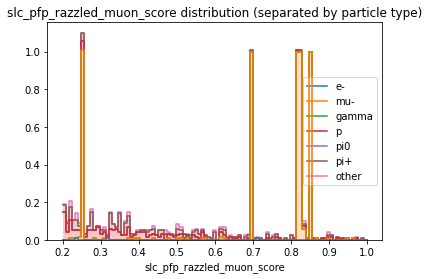

In [304]:
this_nue = esl_trk_nue_df[esl_trk_nue_df.fix_trk_len == esl_trk_nue_df.groupby(slc_idx_set)["fix_trk_len"].transform(max)]
this_bnb = esl_trk_bnb_df[esl_trk_bnb_df.fix_trk_len == esl_trk_bnb_df.groupby(slc_idx_set)["fix_trk_len"].transform(max)]
this_int = esl_trk_int_df[esl_trk_int_df.fix_trk_len == esl_trk_int_df.groupby(slc_idx_set)["fix_trk_len"].transform(max)]
nue.plot_var_pdg(df = [this_nue,this_bnb,this_int]
                 ,scale = [nue.nue_scale,1,int_scale]
                 ,var="slc_pfp_razzled_muon_score"
                 ,bins=np.linspace(0.2,1.0,100))

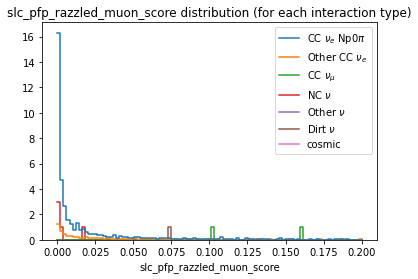

In [308]:
nue.plot_var(df = [this_nue,this_bnb,this_int]
                 ,scale = [nue.nue_scale,1,int_scale]
                 ,var="slc_pfp_razzled_muon_score"
                 ,stacked=False
                 ,bins=np.linspace(0,0.2,100))

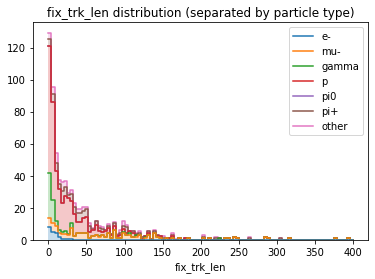

In [241]:
nue.plot_var_pdg(df = [lcr_trk_nue_df,lcr_trk_bnb_df,lcr_trk_int_df]
                 ,scale = [nue.nue_scale,1,int_scale]
                 ,var="fix_trk_len"
                 ,bins=np.linspace(0,400,100))